In [25]:
import itertools
import numpy as np
from scipy.special import comb
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
%%writefile parall_rm.py

import itertools
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from mpi4py import MPI

class RM:
    def __init__(self, m, r):
        self.m = m
        self.r = r
        
    def encode(self, iwd):
        cwd = np.zeros((2**self.m,))
        for i, t in enumerate(itertools.product([0, 1], repeat=self.m)):
            cwd[i] = self._evaluate_polynomial(iwd, t)
        return cwd.astype(np.int)
    
    def cwd_length(self):
        # Calculate codeword length
        return 2 ** self.m

    def iwd_length(self):
        # Calculate information word length
        iwd_length = 0
        for i in range(self.r + 1):
            iwd_length += comb(self.m, i)
        return int(iwd_length)
    
    
    def _evaluate_polynomial(self, poly_coeff, x):
        poly_coef_id = 0  # index for polynomial coefficient
        poly_val = 0
        # Iterate through the monomial power
        for monomial_power in range(self.r + 1):
            # Iterate all fixed power monomials
            for t in itertools.combinations(range(self.m), monomial_power):
                # Evaluate monomial value
                mono_val = poly_coeff[poly_coef_id]
                for j in t:
                    mono_val *= x[j]
                poly_val += mono_val
                poly_coef_id += 1
        return np.mod(poly_val, 2)


    def to_index(self, indexes):
        all_indexes = np.arange(self.m)
        com_indexes = []
        index = 0
        for i in all_indexes:
            if i not in indexes:
                com_indexes.append(i)
        for i in range(len(com_indexes)):
            index += comb(self.m, i)
        for i,t in enumerate(itertools.combinations(range(self.m), len(com_indexes))):
            if list(t) == com_indexes:
                index += i
                break
        return int(index) 

def array_to_string(array):
    string = ''
    for item in array:
        string += str(int(item))
    return string


def msg_to_cdw(msg):
    c = ''
    for item in msg:
        c += (format(int(item,16),'04b'))[::-1] 
    return c

def bin_to_hex(vector):
    final = ''
    array = [(array_to_string(vector))[i:i+4] for i in range(0,len(vector),4)]
    for item in array:
        final += hex(int((item)[::-1],2))[2:]
    return fina

    
st_time = MPI.Wtime()
comm = MPI.COMM_WORLD 
rank = comm.Get_rank()
size = comm.Get_size()



#decode


message = '162ad9b04a86e37a649b97c20b0461c49d6df8a2f20df1a4e0d34620bc8083eae04ff8579b5dd91fef7c5dcea8adbfba02a2d6894a7cc40da73b2645d326f7fd6cdd8893aa14283cd8c3aae4ee0505bb7ef330e8ed6fc512a37b7b093f177efca4680da74c4c8c15cb080b51d323851345dc20df085dfb37e97fe5eaab0ece0d20ced9aec21f6e2a10cd16ad9b75c84015a1d0fd522ac223d5adeff1fb4f94462f7a62382983570da2c4e0890e977f165208ba1068cdb319b6205137264ff2948eb7284b69503053b44e48e835303669f39099a0d7b4427b0a55c5c0b717877de9eaa8014329c101801afd32bcb0025b2919a4c126809764d98f976bbf80cd58ff8b12cc2d6a0c1e77033f1e0f487499b80f5ab8a62277599ad222c02e555a74a1b6b057dcf8c21640ceaed03d80236e26643785cdbc2cad6d497ca88691987f'
c = msg_to_cdw(message)
rm = RM(8,3)
cdw = np.array([int(c[i]) for i in range(len(c))])
real_cdw = np.hsplit(cdw,10)#[0]


vector = {'inf': np.array([]),
         'cdw': np.array([]),
         'err': np.array([])
        }


iwds = []


for codeword in real_cdw:
    m = rm.m
    r = rm.r
    curr_r = r
    iwd_hat = np.zeros(rm.iwd_length())
    
    while(curr_r>=0):
        basis = np.array([2**i for i in range(m - curr_r)])
        all_combs = list(itertools.combinations(range(m), m - curr_r))
        all_len = len(all_combs)
        step = all_len // size
        start_proc, stop_proc = rank*step, (rank+1)*step
        if rank == size - 1:
            stop_proc = all_len 
            
        curr_proc_to_ids = []
        for idx in all_combs[start_proc:stop_proc]:
            b = np.zeros(2**(m - curr_r))
            for i, j in enumerate(itertools.product(range(2), repeat=m)): 
                if r is not m: 
                    indx = np.array(j)[np.array(idx)]@basis
                    b[indx] += codeword[i] 
                    b[indx] -= rm._evaluate_polynomial(iwd_hat,j)
                else:
                    b[0] += rm._evaluate_polynomial(codeword, j)
            if ((b%2).sum() > (b%2).shape[0]/2) == True:
                cs = 1
            else:
                cs = 0
            to_idx = rm.to_index(idx)    
            iwd_hat[to_idx] += cs
            curr_proc_to_ids.append(to_idx)

        #print(f'init iwdhat {iwd_hat}')
        
        gather_iwd_hat = comm.gather(iwd_hat, root=0) 
        gather_idxs = comm.gather(curr_proc_to_ids, root=0)
        
        


        if rank == 0:
            curr_iwd_hat = iwd_hat#np.zeros(rm.iwd_length())
            for proc_iwd, proc_idx in zip(gather_iwd_hat, gather_idxs):
                if len(proc_idx) > 0:
                    curr_iwd_hat[proc_idx] = proc_iwd[proc_idx]
                
            iwd_hat = curr_iwd_hat
            #print(f'rcvd iwdhat {iwd_hat}')
            for curr_rank in range(1, size):
                comm.send(iwd_hat, dest = curr_rank, tag=curr_rank)
        else:
            iwd_hat = comm.recv(source = 0, tag=rank)

            
            
        if rank == 0:
            curr_r = curr_r - 1
            for curr_rank in range(1, size):
                comm.send(curr_r, dest = curr_rank, tag=55+curr_rank)
        else:
            curr_r = comm.recv(source = 0, tag =55+rank)

            
            
            
            
            
    if rank == 0:
#         print(f' iwd{iwd_hat}')
#         print(rm.encode(iwd_hat))
#         print(codeword)
        iwds.append(iwd_hat)
        vector['inf'] = np.hstack([vector['inf'], iwd_hat])
        vector['cdw'] = np.hstack([vector['cdw'], rm.encode(iwd_hat)])
        
if rank == 0:
    vector['err'] = (vector['cdw'] - cdw)%2
    print(array_to_string(vector['err']))

Overwriting parall_rm.py


In [4]:
%%time
!mpirun --allow-run-as-root -n {1} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [14]:
%%time
!mpirun --allow-run-as-root -n {2} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [15]:
%%time
!mpirun --allow-run-as-root -n {3} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [16]:
%%time
!mpirun --allow-run-as-root -n {4} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [22]:
%%time
!mpirun --allow-run-as-root -n {5} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [18]:
%%time
!mpirun --allow-run-as-root -n {6} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [19]:
%%time
!mpirun --allow-run-as-root -n {7} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [24]:
%%time
!mpirun --allow-run-as-root -n {8} python parall_rm.py

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

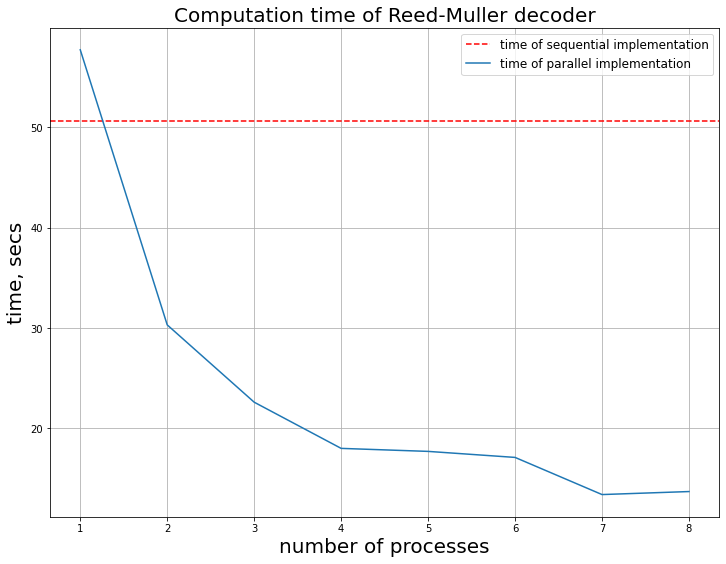

In [26]:
times = [57.7, 30.3, 22.6, 18.0, 17.7, 17.1, 13.4, 13.7]
plt.figure(figsize=(12,9))
plt.title('Computation time of Reed-Muller decoder', fontsize=20)
plt.xlabel('number of processes', fontsize=20)
plt.ylabel('time, secs', fontsize=20)
plt.axhline(y=50.6, color='r', linestyle='--', label = 'time of sequential implementation')
plt.plot(range(1,9), times, label='time of parallel implementation')
plt.legend(loc='best', fontsize=12)
plt.grid(True)
#plt.show()
plt.savefig('rm.png', dpi=100);



